# ECG Split 1D-CNN Server Side
This code is the server part of ECG split 1D-CNN model for **single** client and a server.

## Import required packages

In [14]:
import os
import socket
import struct
import pickle
import time
from pathlib import Path

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
plt.style.use('dark_background')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD

In [20]:
project_path = Path.cwd().parent.parent
print(f'project_path: {project_path}')
save_results = False  # save the loss and accuracy data and graph

project_path: /home/dk/Desktop/split-learning-1D-HE


## Define ECG server model
Server side has **2 fully connected layers**.


In [3]:
class EcgServer(nn.Module):
    def __init__(self):
        super(EcgServer, self).__init__()
        self.linear3 = nn.Linear(32 * 16, 128)
        self.relu3 = nn.LeakyReLU() 
        self.linear4 = nn.Linear(128, 5)
        self.softmax4 = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.linear3(x)
        x = self.relu3(x)        
        x = self.linear4(x)
        x = self.softmax4(x)
        return x

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1070 Ti'

### Set random seed

In [5]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

### Assign intial weight as same as non-split model

In [6]:
ecg_server = EcgServer()
checkpoint = torch.load("init_weight.pth")
ecg_server.linear3.weight.data = checkpoint["linear3.weight"]
ecg_server.linear3.bias.data = checkpoint["linear3.bias"]
ecg_server.linear4.weight.data = checkpoint["linear4.weight"]
ecg_server.linear4.bias.data = checkpoint["linear4.bias"]
ecg_server.to(device)

EcgServer(
  (linear3): Linear(in_features=512, out_features=128, bias=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (linear4): Linear(in_features=128, out_features=5, bias=True)
  (softmax4): Softmax(dim=1)
)

### Set other hyperparameters in the model
Hyperparameters here should be same with the client side.

In [7]:
batch_size = 32
total_batch = 414

epoch = 400
criterion = nn.CrossEntropyLoss()
lr = 0.001
optimizer = Adam(ecg_server.parameters(), lr=lr)

## Socket initialization
### Set host address and port number

### Required socket functions

In [8]:
def send_msg(sock, msg):
    # prefix each message with a 4-byte length in network byte order
    msg = struct.pack('>I', len(msg)) + msg
    sock.sendall(msg)

def recv_msg(sock):
    # read message length and unpack it into an integer
    raw_msglen = recvall(sock, 4)
    if not raw_msglen:
        return None
    msglen = struct.unpack('>I', raw_msglen)[0]
    # read the message data
    return recvall(sock, msglen)

def recvall(sock, n):
    # helper function to receive n bytes or return None if EOF is hit
    data = b''
    while len(data) < n:
        packet = sock.recv(n - len(data))
        if not packet:
            return None
        data += packet
    return data

In [9]:
host = 'localhost'
port = 10080
max_recv = 4096

### Open the server socket

In [10]:
s = socket.socket()
s.bind((host, port))
s.listen(5)

### Wait for Client

In [11]:
conn, addr = s.accept()
print('Conntected with', addr)

Conntected with ('127.0.0.1', 40794)


## Real training process

In [12]:
train_losses = list()
train_accs = list()
test_losses = list()
test_accs = list()
best_test_acc = 0  # best test accuracy

for e in range(epoch):
    print("Epoch {} - ".format(e+1), end='')
    
    train_loss = 0.0
    correct, total = 0, 0
    for i in range(total_batch):
        optimizer.zero_grad()  # initialize all gradients to zero
        msg = recv_msg(conn)  # receive client message from socket
        msg = pickle.loads(msg)  # deserialize
        client_output = msg['client_output']  # client output tensor
        label = msg['label']  # label
        client_output, label = client_output.to(device), label.to(device)
        output = ecg_server(client_output)  # forward propagation
        loss = criterion(output, label)  # calculates cross-entropy loss
        loss.backward()  # backward propagation
        client_grad = client_output.grad.clone().detach()
        msg = pickle.dumps(client_grad)
        send_msg(conn, msg)
        optimizer.step()
        
        train_loss += loss.item()
        correct += torch.sum(output.argmax(dim=1) == label).item()
        total += len(label)
    train_losses.append(train_loss / total_batch)
    train_accs.append(correct / total)
    train_status = "loss: {:.4f}, acc: {:.2f}% / ".format(train_losses[-1], train_accs[-1]*100)
    print(train_status, end='')
        
    with torch.no_grad():  # calculate test accuracy
        test_loss = 0.0
        correct, total = 0, 0
        for j in range(total_batch):
            msg = recv_msg(conn)
            msg = pickle.loads(msg)
            client_output = msg['client_output']
            test_label = msg['label']
            client_output, test_label = client_output.to(device), test_label.to(device)
            test_output = ecg_server(client_output)
            loss = criterion(test_output, test_label)
            
            test_loss += loss.item()
            correct += torch.sum(test_output.argmax(dim=1) == test_label).item()
            total += len(test_label)
        test_losses.append(test_loss / total_batch)
        test_accs.append(correct / total)
        test_status = "test_loss: {:.4f}, test_acc: {:.2f}%".format(test_losses[-1], test_accs[-1]*100)
        print(test_status)
        
    if test_accs[-1] > best_test_acc:
        best_test_acc = test_accs[-1]
    
    msg = pickle.dumps(train_status + test_status)
    send_msg(conn, msg)

Epoch 1 - loss: 1.3244, acc: 59.06% / test_loss: 1.1545, test_acc: 77.38%
Epoch 2 - loss: 1.0868, acc: 83.05% / test_loss: 1.0626, test_acc: 85.08%
Epoch 3 - loss: 1.0519, acc: 85.80% / test_loss: 1.0368, test_acc: 86.90%
Epoch 4 - loss: 1.0411, acc: 86.67% / test_loss: 1.0310, test_acc: 87.67%
Epoch 5 - loss: 1.0351, acc: 87.17% / test_loss: 1.0232, test_acc: 88.29%
Epoch 6 - loss: 1.0326, acc: 87.41% / test_loss: 1.0288, test_acc: 87.70%
Epoch 7 - loss: 1.0279, acc: 87.82% / test_loss: 1.0219, test_acc: 88.40%
Epoch 8 - loss: 1.0250, acc: 88.11% / test_loss: 1.0199, test_acc: 88.53%
Epoch 9 - loss: 1.0253, acc: 87.97% / test_loss: 1.0260, test_acc: 88.04%
Epoch 10 - loss: 1.0234, acc: 88.16% / test_loss: 1.0166, test_acc: 88.80%
Epoch 11 - loss: 1.0207, acc: 88.42% / test_loss: 1.0143, test_acc: 88.97%
Epoch 12 - loss: 1.0202, acc: 88.37% / test_loss: 1.0117, test_acc: 89.26%
Epoch 13 - loss: 1.0194, acc: 88.40% / test_loss: 1.0116, test_acc: 89.25%
Epoch 14 - loss: 1.0170, acc: 88.6

In [13]:
best_test_acc_epoch = np.array(test_accs).argmax() + 1
print('Best test accuracy {:.2f}% in epoch {}.'.format(best_test_acc*100, best_test_acc_epoch))

Best test accuracy 98.49% in epoch 389.


In [15]:
df = pd.DataFrame({  # save model training process into csv file
        'loss': train_losses,
        'test_loss': test_losses,
        'acc': train_accs,
        'test_acc': test_accs
    })

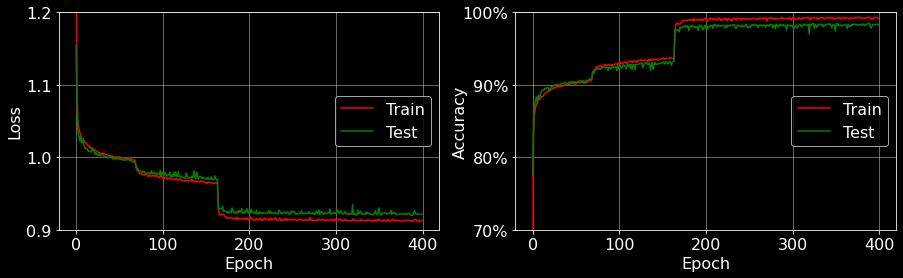

In [18]:
test_accs = df['test_acc']
train_accs = df['acc']
test_losses = df['test_loss']
train_losses = df['loss']

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].plot(train_losses, color='red')
ax[0].plot(test_losses, color='green')
ax[0].set_xticks([0, 100, 200, 300, 400])
ax[0].set_xlabel('Epoch', size=16)
ax[0].set_ylabel('Loss', size=16)
ax[0].set_ylim(0.9, 1.1)
ax[0].set_yticks([0.9, 1.0, 1.1, 1.2])
ax[0].grid(alpha=0.5)
ax[0].tick_params(labelsize=16)
ax[0].legend(['Train', 'Test'], loc='right', fontsize=16)


ax[1].set_ylim(0.7, 1.0)
ax[1].set_yticks([0.7, 0.8, 0.9, 1.0])
ax[1].plot(train_accs, color='red')
ax[1].plot(test_accs, color='green')
yt = ax[1].get_yticks()
ax[1].set_yticklabels(['{:,.0%}'.format(x) for x in yt])
ax[1].set_xticks([0, 100, 200, 300, 400])
ax[1].set_xlabel('Epoch', size=16)
ax[1].set_ylabel('Accuracy', size=16, labelpad=-5)
ax[1].grid(alpha=0.5)
ax[1].tick_params(labelsize=16)
ax[1].legend(['Train', 'Test'], loc='right', fontsize=16)

In [ ]:
if save_results:
    df.to_csv('losses_accs.csv')
    fig.savefig('losses_accs.png', bbox_inches='tight')